# Google Cloud Parallel Data Read Speeds with Dask - Local Cluster

This benchmarking was inspired by the [Abernathey et al. (2021)](https://www.computer.org/csdl/magazine/cs/2021/02/09354557/1reXu4gJjri) paper, which includes a detailed analysis and discussion of cloud-native big scientific data, the role of data-proximate computing in accelerating computation times, analysis-ready data, and more. It is recommended that a reader unacclimated with this subject matter first studies its information before going through this notebook.

Unfortunately, due to the access token required to retrieve data the Google Cloud Storage Bucket used in this benchmarking, the public reader will not be able to run this notebook on their own. If you wish to download your own copy and alter the code, the test data from [NOAA's ETOPO1 Global Relief Model](https://www.ngdc.noaa.gov/mgg/global/relief/ETOPO1/data/ice_surface/grid_registered/netcdf/) can be found here. A file transformation notebook is also found within the repository, which documents my methods for converting from the original NetCDF format. Note that a CSV version was created outside of this project space using Generic Mapping Tools (GMT). A validation notebook has also been included in the repository to test each file type for the correct data contents.

Different methods for accessing Google Cloud Storage are used--contigent on the file type of the data. Though discussed in further detail later on, I encourage the reader to familiarize themsevles with the different file formats used in this benchmarking, as well as the access APIs. In many instances, cloud data store locations can be represented as a Dask Array with a single function call; for the instances that this is not possible, other Python libraries are used with no detriment to read speeds.

A significant portion of the code used in this benchmarking is directly taken from [Ryan Abernathey's demonstration notebook](https://github.com/earthcube2020/ec20_abernathey_etal/blob/master/cloud_storage.ipynb), and it is worth viewing before beginning this read.

 **NetCDF3, which is the original format of the** `ETOPO1_Ice_g_gmt4.nc` **file, does not support internal chunking. If you choose to download the data from the previously provided link, it must first be converted into NetCDF4 in order to successfully run the entire notebook. In order to read the NetCDF4 file efficiently, chunk sizes will likely need to be manually specified using a tool like PyFerret.**

-------------------------------------------------------------------------------------------------------------------------------

## Testing Environment & Results

Machine Specifications Used to Generate Results:
* Machine Type: Google Compute Engine n2-standard-16
* CPU: 16 vCPUs
* Memory: 64 GB

The benchmark was completed by running each of the file types through the testing process five times using the ETOPO1 Global Relief Model Data. Results were generated using cloud workers, so read operations over a home network will likely be much slower than what is presented. We also expect the following figure to have some variation each time it is re-created using cloud workers, but the throughput distribution essentially remains the same.

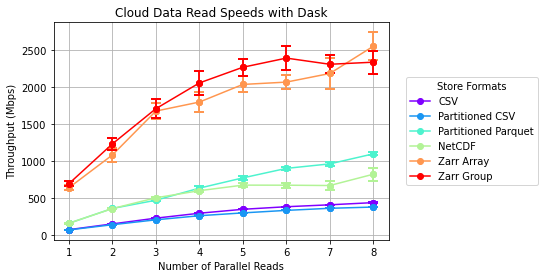

First, let us study the read speeds of the legacy file formats (CSV, Partitioned CSV, & NetCDF). Clearly the CSVs are significantly slower than Parquet, with the only similar throughput rates occuring at one worker. NetCDF has good scaling relative to the CSV versions of the same data but has a much larger disparity between its read speed and its corresponding cloud format. The errors for classic versions are also extremely small when measured against the cloud-native formats, but do not warrant their use in big data anaylsis. In fact, the only purpose of including these legacy formats is to demonstrate how much slower they are than Parquet and Zarr. The read throughput is far too small for use in larger-scale testing but provides an interesting comparison in this local context.

Initial observations of read speed for the cloud native formats is promising given the large increase in throughput from CSV & NetCDF. The read also scales well through the entire test range, but a slight decrease in throughput increase rate is observed at four workers for Zarr. One hypothesis considers that the file size may be too small to allow a significant speed increase past around four workers, but this idea does not explain why the predicted behavior occurs for all other file formats. Planned future testing on a distributed cluster of high-perfomance machines could show different throughput distributions or confirm this particular trend. All things considered, Zarr boasts a massive speed increase from NetCDF (~1.5 Gbps difference at six workers!) and is the best option when working with gridded data.

Parquet shows the most stable read throughput scaling of all formats, and is certainly a huge improvement from the traditional CSV format speeds. When using tabluar data, Parquet is clearly the best choice -- specifically when it is partitioned into subsets within cloud storage. Changing the size of these partitions from what Dask automatically allocates has not been tested but could offer further speed increases when done correctly.

This notebook is by no means a full representation of the capabilities of cloud-native data formats' ability to scale, so future tests with higher-performance hardware will be conducted in a separate notebook. However, this benchmarking is a great example of what one can expect when operating on a single cloud-based machine and can help inform format decisions for work that requries the use of larger-than-memory data.

-------------------------------------------------------------------------------------------------------------------------------

## Imports & Client Initialization

In [ ]:
import dask.array as dsa
import numpy as np
import dask.dataframe as dd
from contextlib import contextmanager
import xarray as xr
import intake
import time
import dask
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.ticker import MaxNLocator
import matplotlib.colors
import pandas as pd
from scipy.stats import sem
import tiledb

The value of `threads_per_worker` was chosen to allow all cores of the local machine to be used when scaling to 8 workers.

In [ ]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(threads_per_worker=2)
client = Client(cluster)

## Benchmarking Setup

First, we will create this null storage object. To measure our throughput, all of the data will need to be accessed at a single time and can be achieved by storing the data into this null storage target.

In [ ]:
class DevNullStore:
    def __init__(self):
        pass
    def __setitem__(*args, **kwargs):
        pass

null_store = DevNullStore()

The Diagnostic Timer will keep track of data retrieval times and store them within a Pandas DataFrame for later processing and analysis.

In [ ]:
class DiagnosticTimer:
    def __init__(self):
        self.diagnostics = []
        self.names = []
        
    @contextmanager
    def time(self, **kwargs):
        tic = time.time()
        yield
        toc = time.time()
        kwargs["runtime"] = toc - tic
        self.diagnostics.append(kwargs)
        
    def dataframe(self):
        return pd.DataFrame(self.diagnostics)
    
diag_timer = DiagnosticTimer()

This naming function will keep track of our read throughput for each file format and make it easier to plot all of the cases.

In [ ]:
def name(fileType, daf): 
    globals()[f"df_{fileType}"] = daf
    diag_timer.names.append(globals()[f"df_{fileType}"])
    
    global df, da
    del df, da
    diag_timer.diagnostics = []

Information about our cluster is also collected during the tests. Importantly, the number of parallel reads will correspond to the total number of workers.

In [ ]:
def total_nthreads():
    return sum([v for v in client.nthreads().values()])

def total_ncores():
    return sum([v for v in client.ncores().values()])

def total_workers():
    return len(client.ncores())

This is the main loop. A few modifications have been made from Abernathey's original version, but most notably an error calculation has been added. In the case that the user wishes to run multiple tests for each file format, the `errorCalc(...)` function will calculate the error and the mean throughput & runtime for each file format.

In [ ]:
class mainLoop:
    def errorCalc(self, df0):
        global tests
        newVals = []
        info = []
        thrPut = df0['throughput_Mbps']
        rTime = df0['runtime']
        for i in np.linspace(0, len(thrPut)-tests, int(len(thrPut)/tests), dtype='int'):
            means = thrPut[slice(i,(i+tests))].mean()
            runtime = rTime[slice(i,(i+tests))].mean()
            errors = sem(thrPut[slice(i,(i+tests))])
            error_kwargs = dict(runtime = runtime, throughput_Mbps = means, errors = errors)
            info.append(df0.iloc[i, 0:7])
            newVals.append(error_kwargs)
        
        df1 = pd.DataFrame(info, index=range(len(info)))
        df2 = pd.DataFrame(newVals)
        df = pd.concat([df1, df2], axis=1)
        return df

    def loop(self, da, diag_kwargs):
        global tests, max_workers, worker_step
        for nworkers in np.flip(np.arange(max_workers, 0, -worker_step)):
            cluster.scale(nworkers)
            time.sleep(10)
            client.wait_for_workers(nworkers)
            print('Number of Workers:', nworkers)
            for i in range(tests):
                with diag_timer.time(nworkers=total_workers(), nthreads=total_nthreads(), ncores=total_ncores(),
                                     **diag_kwargs):
                    future = dsa.store(da, null_store, lock=False, compute=False)
                    dask.compute(future, retries=5)
                del future
        
        df = diag_timer.dataframe()
        df['throughput_Mbps'] = da.nbytes / 1e6 / df['runtime']
        if i != 0:
            df = self.errorCalc(df)
        return df

mainLoop = mainLoop()

---------------

## Perform Benchmarking

Though we are accessing the data from different formats, the core process will be the exact same. Dask is lazy by default, which means we will be using the previously defined `null_store` to measure throughput. Converting from DataFrames to Arrays, for example, will not affect the access speed because the data is not actually read from the source until we "store" it. So, these read speeds should be the same whether you are initially pointing to data using a DataFrame or Array. The time to collect and interpret the metadata of each file format will be measured with `connectTime`, which is important when using different access methods, e.g. Dask or Xarray.

###  User Input for Testing Conditions

Here, the user will define the testing benchmarking conditions:
* **`tests = (int)`:** The number of times each individual file format will be read for measurement. Entering a number greater than 1 will take much longer to run, but results will include errors & throughput plot will have error bars.


* **`max_workers = (int)`:** Maximum amount of parallel reads to be tested.


* **`worker_step = (int)`:** Workers will be reduced by this number starting from the value of `max_workers` until the lowest possible value is reached. For instance, when `max_workers = 8` & `worker_step = 2`, the resulting worker scaling scheme will be `[2, 4, 6, 8]`.


* **`root = (string)`:** Root uniform resource identifier (URI) of the object storage location. Can be changed to a public URL for public data.


* **`data = (string)`:** The data set to test. Within the `gs://cloud-data-benchmarks` bucket, each file format begins with the same naming convention, with the only difference being the extension at the end of the file name -- e.g. `.nc`, `.zarr`, etc. If the user is providing their own data and bucket, ensure that the naming convention follows what was done for this notebook, or hardcode the object storage URIs in each applicable function call.

Note: When using a data set that only has gridded formats available in cloud object storage, only run the **Gridded Data** section of the notebook. The **Tabluar Data** section will *not* work.

In [ ]:
# Loop Parameters
tests = 5
max_workers = 8
worker_step = 1

# Data Location
root = 'gs://cloud-data-benchmarks/'
data = 'ETOPO1_Ice_g_gmt4'

### Tabular Data

Tabular data will only be tested with the ETOPO1 topography data because larger data sets will take much longer to convert and test.

#### CSV

This is the classic tabular data format. Students & professionals alike use this format due to its simplicity and flexibility bewteen applications. As you will see, this format has the slowest read times of all being tested but is included in the benchmarking given its widespread use.

##### Single File

In [ ]:
tic1 = time.time()
df0 = dd.read_csv(root + data + '.csv', assume_missing=True, names=['lon', 'lat', 'z'])
toc1 = time.time()
connectTime = toc1-tic1

da = df0.to_dask_array(lengths=True)
del df0
chunksize = np.prod(da.chunksize) * da.dtype.itemsize
da

In [ ]:
diag_kwargs = dict(nbytes=da.nbytes, chunksize=chunksize, format='CSV', connectTime=connectTime)

df = mainLoop.loop(da, diag_kwargs)
name('csv', df)
df_csv

##### Multiple Files

While one CSV file is the most common way one will see data of this format presented, we are interested in determining if partitioning (splitting up) the data into file sizes automatically determined by Dask will speed up the read from cloud storage. The process is the exact same, with the exception of a minor amount of required preprocessing.

In [ ]:
tic1 = time.time()
df0 = dd.read_csv(root + data + '.partcsv/*', assume_missing=True, names=['lon', 'lat', 'z'])
toc1 = time.time()
connectTime = toc1-tic1

da = df0.to_dask_array(lengths=True)
del df0
chunksize = np.prod(da.chunksize) * da.dtype.itemsize
da

In [ ]:
diag_kwargs = dict(nbytes=da.nbytes, chunksize=chunksize, format='Partitioned CSV', connectTime=connectTime)

df = mainLoop.loop(da, diag_kwargs)
name('partcsv', df)
df_partcsv

#### Parquet

Parquet is a cloud-native format for tabular data that is very useful when working with large CSV files. Strictly speaking, any single-indexed DataFrame can be converted into Parquet files using Dask, making this a very attractive format when performing computations in parallel. Smaller files can be converted into Parquet using Pandas but parallel processing functionality will suffer as a consequence.

##### Multiple Files

In [ ]:
tic1 = time.time()
df0 = dd.read_parquet(root + data + '.partparquet/*')
toc1 = time.time()
connectTime = toc1 - tic1

da = df0.to_dask_array(lengths=True)
del df0
chunksize = np.prod(da.chunksize) * da.dtype.itemsize
da

In [ ]:
diag_kwargs = dict(nbytes=da.nbytes, chunksize=chunksize, format='Partitioned Parquet', connectTime=connectTime)

df = mainLoop.loop(da, diag_kwargs)
name('partparquet', df)
df_partparquet

##### Single File

**BE AWARE THAT THIS SINGLE PARQUET FILE WILL NOT RUN TO COMPLETION. THE KERNEL WILL HAVE TO BE RESET IF THE CELLS IN THIS SECTION ARE EXECUTED. SEE REASONING BELOW.**

We encounter a problem with large unmanaged memory when attempting to compute the size of DataFrame. This format is used here as an example of a file format that will not work in parallel, and should **only** be run to demonstrate a use case that does not function.

Generally, it is recommended that parquet files be partitioned in advance to avoid this issue. Dask currently creates DataFrame partitions based on the number of files stored within the parquet file path. Having one large file goes against the point of switching to parquet files in the first place because Dask will not be able to partition the data for parallel processing.

In [ ]:
tic1 = time.time()
df0 = dd.read_parquet(root + data + '.parquet')
toc1 = time.time()
connectTime = toc1 - tic1

# Memory Problem between these print statements. This may execute if the user's resources provide ample memory.
print("Calculating size of array")
da = df0.to_dask_array(lengths=True)
print("Size of array has been calculated")

del df0
chunksize = np.prod(da.chunksize) * da.dtype.itemsize
da

In [ ]:
diag_kwargs = dict(nbytes=da.nbytes, chunksize=chunksize, format='Parquet', connectTime=connectTime)

df = mainLoop.loop(da, diag_kwargs)
name('parquet', df)
df_parquet

### Gridded Data

Gridded formats often contain multiple data variables, but cannot be represented in a single Dask Array (which is required for this benchmarking method to work).


If you do not have a NetCDF file available in cloud storage and wish to test only Zarr formatted data, replace the following cell with

`xr.open_zarr(store = root + '[Your Zarr Group Directory]').data_vars` to view all data variables in the data set. This will give the same output as the NetCDF version.

In [ ]:
intake.open_netcdf(root + data + '.nc').to_dask().data_vars # Lists all data variables contained in the data set.

`variable = (string)` Choose a data variable from the list in the output above to use in read testing.

In [ ]:
variable = 'Z1'

#### NetCDF

NetCDF files are extremely common in geospatial and climate science, which is the original format of the test data used in this benchmarking. Data from these fields are commonly very large, with sizes only increasing as missions collecting samples at higher resolutions are conducted. The informed scientist should have a good grasp on the speed limitations of this format and the best ways to load in and perform computations within Python.

We load the NetCDF using the `intake` library. This is a great way to load the data from GCS without directly using the `gcsfs` module. Depending on the NetCDF file contents, decoding the data using the engines included with `xarray.open_dataset(...)` can be troublesome. Read the XArray documentation about accessing files using `xarray.open_dataset(...)` [here](https://docs.xarray.dev/en/stable/user-guide/io.html).

The `intake` module is much easier to use, and offers some additional functionality in the form of catalogs. Read about catalogs and their uses [here](https://intake.readthedocs.io/en/latest/catalog.html).

**NOTE ON INTAKE-XARRAY:**
- To perform an efficient read, the Dask array that references the NetCDF4 file must have chunk sizes configured to exactly match or be exact multiples of the data's internal chunks.


- In this benchmarking the correct Dask chunks are automatically set for the user once a data variable is selected, but it is best to be informed of this behavior for future use.

In [ ]:
tic1 = time.time()
ds = intake.open_netcdf(root + data + '.nc').to_dask()
toc1 = time.time()
connectTime = toc1-tic1

# Set Dask chunks to match internal chunks
internal_chunks = ds[variable].encoding['chunksizes']
coords = ds[variable].dims
da = ds[variable].chunk(chunks=dict(zip(coords, internal_chunks))).data

chunksize = np.prod(da.chunksize) * da.dtype.itemsize
del ds
da

In [ ]:
diag_kwargs = dict(nbytes=da.nbytes, chunksize=chunksize, format='NetCDF', connectTime=connectTime)

df = mainLoop.loop(da, diag_kwargs)
name('netcdf', df)
df_netcdf

#### Zarr

Zarr Groups/Arrays are cloud-native gridded data formats, making them a very useful alternative to NetCDF. It is known that there will be a large speedup with cloud read speed compared to the legacy data formats, but the difference in performance between a Group/Array is important to note.

A Zarr Group is a very good choice of storage utility for multiscale data due to its hierarchical paths in an object storage system -- this allows many different data sets to be stored in subdirectories under a larger Zarr store directory. A Zarr Array can only store a single data variable at a time, so multi-variate data sets will have to be represented by multiple Zarr Arrays.

##### Zarr Array

In [ ]:
tic1 = time.time()
da = dsa.from_zarr(root + data + '.zarray')
toc1 = time.time()
connectTime = toc1 - tic1
chunksize = np.prod(da.chunksize) * da.dtype.itemsize
da

In [ ]:
diag_kwargs = dict(nbytes=da.nbytes, chunksize=chunksize, format='Zarr Array', connectTime=connectTime)

df = mainLoop.loop(da, diag_kwargs)
name('zarray', df)
df_zarray

##### Zarr Hierachical Group

Xarray provides a fantasic tool in their API for opening Zarr groups. By consolidating the metadata upon creation of the group, the read speed increases considerably more than if it was left in its base state.

In [ ]:
tic1 = time.time()
ds = xr.open_zarr(store = root + data + '.zarr', consolidated=True)
toc1 = time.time()
connectTime = toc1-tic1
da = ds[variable].data
del ds
chunksize = np.prod(da.chunksize) * da.dtype.itemsize
da

In [ ]:
diag_kwargs = dict(nbytes=da.nbytes, chunksize=chunksize, format='Zarr Group', connectTime=connectTime)

df = mainLoop.loop(da, diag_kwargs)
name('zgroup', df)
df_zgroup

#### TileDB Embedded 

More than just a data format, [TileDB Embedded](https://docs.tiledb.com/main/) is best described as an engine whose strengths manifest themselves in extremely fast multidimensional slicing; storage of tabluar data (something Zarr cannot do); complete integration with Amazon S3, Google Cloud Storage, and Microsoft Azure; and multi-attribute (data variable) storage under a single folder. Both Dense and Sparse arrays are supported, and direct integrations with many APIs make TileDB Embedded a robust and flexible cloud-native data format.

In [ ]:
tic1 = time.time()
da = dsa.from_tiledb(root + data + '.tldb')
toc1 = time.time()
connectTime = toc1 - tic1
chunksize = np.prod(da.chunksize) * da.dtype.itemsize
da

In [ ]:
diag_kwargs = dict(nbytes=da.nbytes, chunksize=chunksize, format='TileDB Embedded', connectTime=connectTime)

df = mainLoop.loop(da, diag_kwargs)
name('tldb', df)
df_tldb

-------------------------------------------------------------------------------------------------------------------------------

In [ ]:
client.close()
cluster.close()

## Plot Throughput

This class will automatically check if each file type was tested more than once to determine if errors bars should be included in the throughput figure.

In [ ]:
class errorPlot:
    def plot(self):
        x = self.df['nworkers']
        y = self.df['throughput_Mbps']
        error = self.df['errors']
        plt.errorbar(x, y, yerr=error, color=self.c, fmt='o', capsize=5, capthick=2)
        
    def errorCheck(self, daf, color):
        self.c = color
        self.df = daf
        try:
            self.plot()
        except:
            pass
        else:
            self.plot()
            
errorPlot = errorPlot()

All tests performed are plotted with throughput as a function of parallel reads. Note that if the same file format cells are tested more than once before the kernel is restarted, *all* output DataFrames will be shown on the plot. For example, if the Zarr Group cells are executed twice in total, two different sets of points will be plotted for that same file format. This is easy to observe on the legend, where the user would see two store formats titled "Zarr Group".

In [ ]:
color = cm.rainbow(np.linspace(0,1,len(diag_timer.names)))
legend = []
df_results = pd.concat(diag_timer.names, ignore_index=True)

for i in range(len(diag_timer.names)):
    legend.append(diag_timer.names[i]['format'][1])
    c = matplotlib.colors.to_hex(color[i,:], keep_alpha=True)
    
    if i == 0:
        ax = diag_timer.names[i].plot(x='nworkers', y='throughput_Mbps', kind='line', color=c, marker='o')
    else:
        diag_timer.names[i].plot(x='nworkers', y='throughput_Mbps', kind='line', color=c, ax=ax, marker='o')
        
    errorPlot.errorCheck(diag_timer.names[i], c) 
    plt.grid(True)
    plt.title('Cloud Data Read Speeds with Dask')
    plt.xlabel('Number of Parallel Reads')
    plt.ylabel('Throughput (Mbps)')
    plt.legend(legend, bbox_to_anchor=[1.25, 0.5], loc='center', title='Store Formats')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #plt.yscale('symlog') ACTIVATE THIS LINE IF YOU ARE USING A LARGE AMOUNT OF WORKERS

In [ ]:
df_results